주식 시계열 예측

CNN, RNN, LSTM 등 Base Model 생성


Regression이니 Dense layer 출력층 1인것에 유의

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv('./drive/MyDrive/train.csv', index_col=0)
df

,종목코드,종목명,거래량,시가,고가,저가,종가
일자,,,,,,,
20210601,A060310,3S,166690,2890,2970,2885,2920
20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
20210601,A054620,APS,462544,14600,14950,13800,14950
20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...
20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
20230530,A000540,흥국화재,50218,3250,3255,3195,3215
20230530,A003280,흥아해운,130664,1344,1395,1340,1370


In [23]:
# '종목코드' column 값이 'A060310'인 데이터 추출
df = df[df['종목코드'] == 'A060310']
df

,종목코드,종목명,거래량,시가,고가,저가,종가
일자,,,,,,,
20210601,A060310,3S,166690,2890,2970,2885,2920
20210602,A060310,3S,134833,2915,2975,2830,2900
20210603,A060310,3S,144470,2900,2925,2875,2900
20210604,A060310,3S,934224,2930,3120,2920,2950
20210607,A060310,3S,946560,3000,3150,2955,3150
...,...,...,...,...,...,...,...
20230523,A060310,3S,117084,2300,2315,2260,2285
20230524,A060310,3S,67101,2280,2300,2255,2280
20230525,A060310,3S,91789,2260,2285,2235,2245


In [24]:
#결측치 측정
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 20210601 to 20230530
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종목코드    494 non-null    object
 1   종목명     494 non-null    object
 2   거래량     494 non-null    int64 
 3   시가      494 non-null    int64 
 4   고가      494 non-null    int64 
 5   저가      494 non-null    int64 
 6   종가      494 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 30.9+ KB
None


- X=['Open', 'High', 'Low']
- y=['Close']

In [25]:
df.shape

(494, 7)

In [26]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

In [27]:
dfx = df[['시가', '고가', '저가', '종가']]
dfx = MinMaxScaler(dfx)

dfy = dfx[['종가']]
dfx = dfx[['시가', '고가', '저가']]

dfx

,시가,고가,저가
일자,,,
20210601,0.362534,0.347349,0.420705
20210602,0.372311,0.349177,0.396476
20210603,0.366445,0.330896,0.416300
20210604,0.378178,0.402194,0.436123
20210607,0.405553,0.413163,0.451542
...,...,...,...
20230523,0.131795,0.107861,0.145374
20230524,0.123973,0.102377,0.143172
20230525,0.116152,0.096892,0.134361


In [28]:
dfx.describe()

,시가,고가,저가
count,494.000000,494.000000,494.000000
mean,0.388270,0.371748,0.428200
std,0.223416,0.216861,0.243649
min,0.000000,0.000000,0.000000
25%,0.158193,0.154022,0.174559
50%,0.390888,0.384826,0.431718
75%,0.534611,0.504113,0.583700
max,1.000000,1.000000,1.000000


In [29]:
dfy.head()

,종가
일자,
20210601,0.358925
20210602,0.351248
20210603,0.351248
20210604,0.370441
20210607,0.447217


In [30]:
#시분할
time_step = 10
step = 1

def create_dataset(X, y, time_step, step):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step):
        v = X.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        Xs.append(v)
        ys.append(labels)

    return np.array(Xs), np.array(ys)

In [31]:
X, y = create_dataset(dfx, dfy, time_step, step)

X.shape

(484, 10, 3)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((324, 10, 3), (160, 10, 3), (324, 1), (160, 1))

#Deep Learning

###RNN

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout

In [34]:
model = Sequential([
    SimpleRNN(20, activation='relu', input_shape=(X.shape[1:]), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(20, activation='relu'),
    Dropout(0.3),
    Dense(1)  #Regression에서는 출력범위가 1
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 20)            480       
                                                                 
 dropout (Dropout)           (None, 10, 20)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1321 (5.16 KB)
Trainable params: 1321 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model.compile(loss='mse', optimizer='adam')

In [36]:
#train
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.33, shuffle=False)

Epoch 1/500
7/7 [==============================] - 9s 80ms/step - loss: 0.4506 - val_loss: 0.0145
Epoch 2/500
7/7 [==============================] - 0s 26ms/step - loss: 0.2545 - val_loss: 0.0044
Epoch 3/500
7/7 [==============================] - 0s 26ms/step - loss: 0.1949 - val_loss: 0.0050
Epoch 4/500
7/7 [==============================] - 0s 29ms/step - loss: 0.2195 - val_loss: 0.0031
Epoch 5/500
7/7 [==============================] - 0s 25ms/step - loss: 0.1611 - val_loss: 0.0035
Epoch 6/500
7/7 [==============================] - 0s 23ms/step - loss: 0.1231 - val_loss: 0.0045
Epoch 7/500
7/7 [==============================] - 0s 24ms/step - loss: 0.1021 - val_loss: 0.0049
Epoch 8/500
7/7 [==============================] - 0s 27ms/step - loss: 0.0921 - val_loss: 0.0043
Epoch 9/500
7/7 [==============================] - 0s 26ms/step - loss: 0.0884 - val_loss: 0.0035
Epoch 10/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0747 - val_loss: 0.0041
Epoch 11/500
7/7 [=

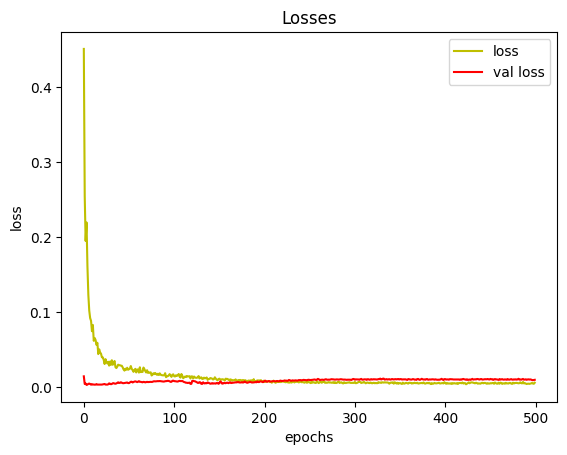

In [37]:
#loss 시각화
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [38]:
#예측
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 6ms/step


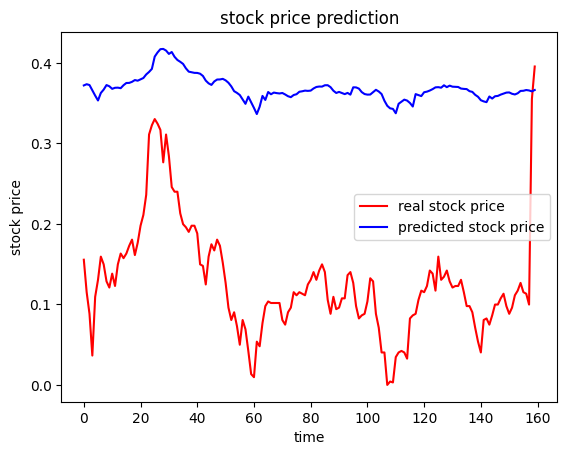

In [39]:
#예측-실 오차 시각화
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

###LSTM

In [40]:
from keras.layers import LSTM

In [41]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
n_timesteps, n_features, n_outputs

(10, 3, 1)

In [44]:
#모델 생성

model = Sequential([
    LSTM(100, input_shape=(n_timesteps,n_features)),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(1)  #Regression에서는 출력범위가 1
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               41600     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 51801 (202.35 KB)
Trainable params: 51801 (202.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
model.compile(loss='mse', optimizer='adam')

In [46]:
#train
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.33, shuffle=False)

Epoch 1/500
7/7 [==============================] - 4s 109ms/step - loss: 0.1404 - val_loss: 0.0201
Epoch 2/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0393 - val_loss: 0.0041
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0247 - val_loss: 0.0037
Epoch 4/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0237 - val_loss: 0.0053
Epoch 5/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0205 - val_loss: 0.0056
Epoch 6/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0185 - val_loss: 0.0031
Epoch 7/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.0037
Epoch 8/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0188 - val_loss: 0.0053
Epoch 9/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0170 - val_loss: 0.0039
Epoch 10/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0148 - val_loss: 0.0036
Epoch 11/500
7/7 [

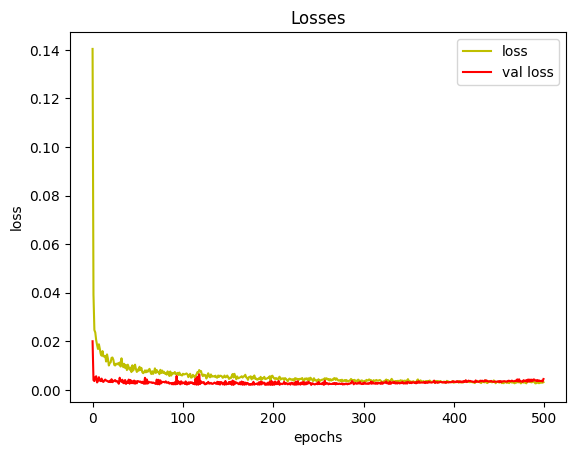

In [47]:
#loss 시각화
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [48]:
#예측
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


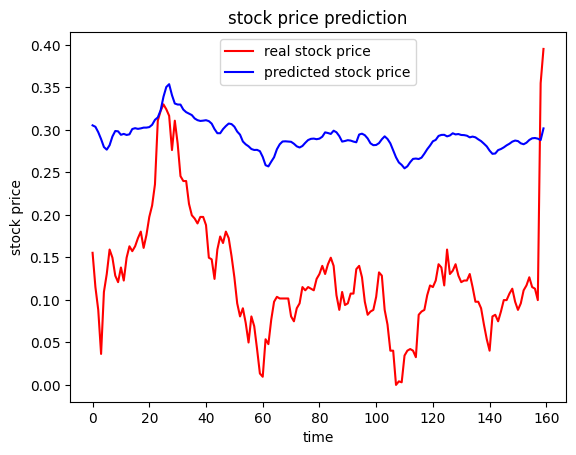

In [49]:
#예측-실 오차 시각화
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()